In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import readsav

import re

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from matplotlib.pylab import *
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter

rcParams['figure.figsize'] = (10,8)
rcParams['font.size'] = 22

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import igm as lyA
import buildFluxTables as bft

import linecache
import os
import subprocess
import glob
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [3]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
cosmo = FlatLambdaCDM(H0=73.2, Om0=0.24, Ob0=0.0449,name='myCosmo')

In [4]:
cosmo.luminosity_distance(z=1.0)
# Matches Ned's calc: The luminosity distance DL is 6560.5 Mpc or 21.398 Gly. 

<Quantity 6560.467651039068 Mpc>

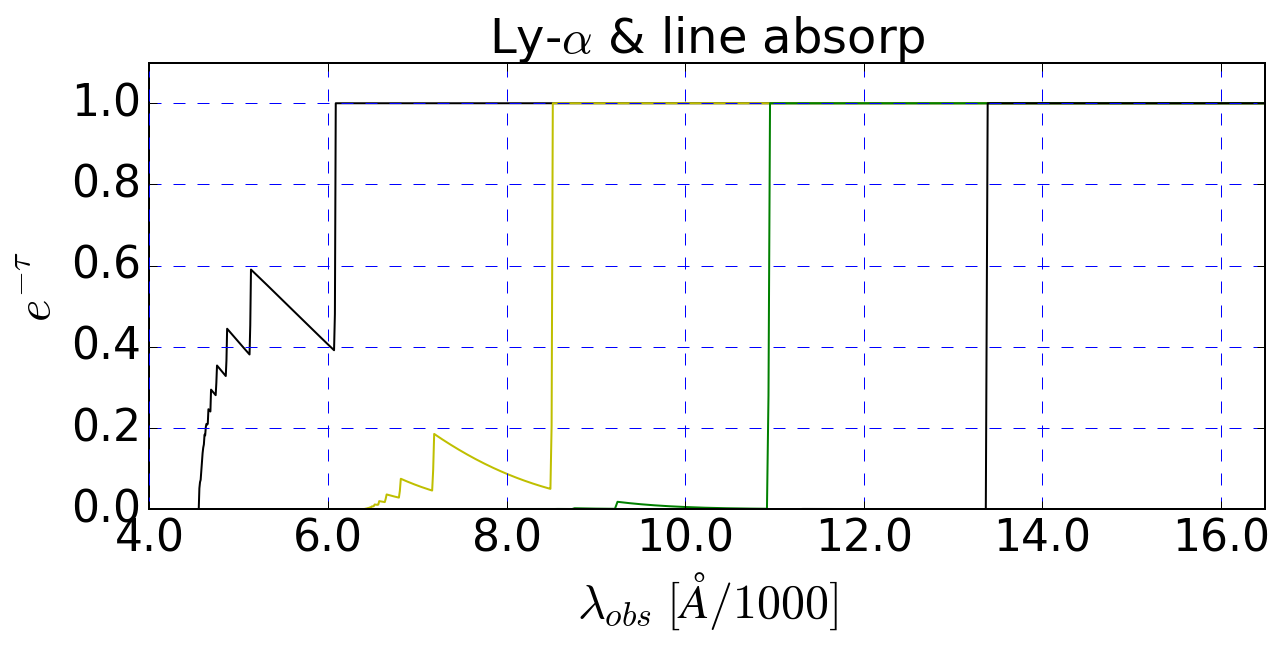

In [5]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
lamRange = np.logspace(1.95,5.7,5500)
ax.plot(lamRange,lyA.lyTauC(4.0)(lamRange),'k-',
        lamRange,lyA.lyTauC(6)(lamRange),'y-',
        lamRange,lyA.lyTauC(8)(lamRange),'g-',
        lamRange,lyA.lyTauC(10)(lamRange),'k-')
ax.set_xlim([4000,16500])
ax.set_ylim([1e-9,1.1])
ax.set_ylim([0,1.1])
#ax.set_yscale('log')
ax.set_ylabel(r'$e^{-\tau}$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)


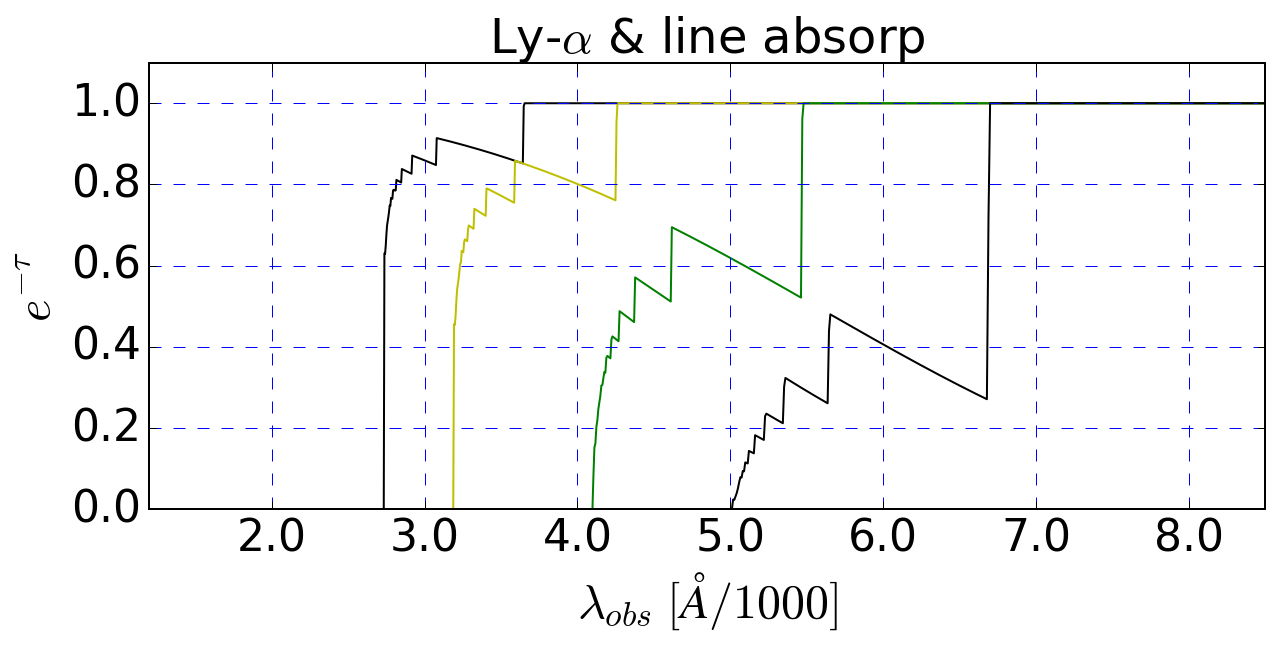

In [6]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
lamRange = np.logspace(1.95,5.7,5500)
ax.plot(lamRange,lyA.lyTauC(2.0)(lamRange),'k-',
        lamRange,lyA.lyTauC(2.5)(lamRange),'y-',
        lamRange,lyA.lyTauC(3.5)(lamRange),'g-',
        lamRange,lyA.lyTauC(4.5)(lamRange),'k-')
ax.set_xlim([1200,8500])
ax.set_ylim([1e-9,1.1])
ax.set_ylim([0,1.1])
#ax.set_yscale('log')
ax.set_ylabel(r'$e^{-\tau}$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)


# Load SB99 data... 

In [7]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# REMEMBER, SB99 data is for a population of 1e6 M_sun
# THIS IS WHY I HAVE "-6" when constructing the flux per wavelen below... 
SB99Path = '/Users/earnric/OneDrive/Software-Models/STARBURST99/STARBURST99-runs/' # Home computer dir... 
SB99Dirs = ['padova0004-op/','padova004-op/','padova008-op/','padova02-op/'] # Dense SED (in age)
Zs       = [0.0004, 0.004, 0.008, 0.02]
SB99FilePat = 'padova*.spectrum1'

# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
for i, (Z, SB99Dir) in enumerate(zip(Zs,SB99Dirs)):
    SB99FilePattern = SB99Path + SB99Dir + SB99FilePat 
    SB99Files   = glob.glob(SB99FilePattern)  # All the files in the dir... should be one!
    if len(SB99Files) != 1:
        print('Error: too many files in an SB99 dir! - ',SB99Path + SB99Dir)
        sys.exit()
    SB99Data    = np.loadtxt(SB99Files[0],skiprows=6)
    if i == 0:
        SB990004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 1:
        SB99004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 2:
        SB99008 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 3:
        SB9902 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    # We now have:
    # [[log age, waveln, flux], [], ...]


In [8]:
np.unique(SB99004[:,0])[0:20]

array([ 4.        ,  5.70757018,  6.00432137,  6.17897695,  6.30319606,
        6.39967372,  6.4785665 ,  6.54530712,  6.60314437,  6.65417654,
        6.69983773,  6.7411516 ,  6.77887447,  6.81358099,  6.84571802,
        6.87563994,  6.90363252,  6.92992956,  6.95472479,  6.97818052])

In [17]:
restUV_A = {i: (1500.0 * (1+i))* u.angstrom for i in 
                         [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]}
restUV_Hz = {i: (1500.0 * (1+i) * u.angstrom).to(u.Hz, equivalencies=u.spectral()) for i in 
                         [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]}
sorted(restUV_Hz.keys())

[2.0,
 3.0,
 4.0,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0]

In [19]:
restUV_Hz[2.0],restUV_A[2.0],(1500*(1+2) * u.Angstrom).to(u.Hz, equivalencies=u.spectral())

(<Quantity 666205462222222.1 Hz>,
 <Quantity 4500.0 Angstrom>,
 <Quantity 666205462222222.1 Hz>)

In [ ]:
redshifts    = [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
# redshifts    = [2.0,3.0,6.0]
sb99List  = [SB990004, SB99004, SB99008, SB9902]
sb99Names = ["SB990004", "SB99004", "SB99008", "SB9902"]
# sb99List  = [SB9902]
# sb99Names = ["SB9902-TEST"]
hdr = 'LogAge, redshift, 1500_Ang_restFlux'
fmtStr = '%.4f, %.1f, %.4e'
print(hdr)
for sb99Data, fname in zip(sb99List,sb99Names):
    ages = np.unique(sb99Data[:,0]) # Get the list of ages
    # Get the log age, wavelength & Luminosity/s/Ang
    allAges = sb99Data[:,0]
    wavelns = sb99Data[:,1] * u.Angstrom
    LperA   = sb99Data[:,2] * u.erg / u.second / u.angstrom
    for z in redshifts:
        prevAge = 0.0
        outfile = []
        print("working {} at z={:.1f}".format(fname,z))
        absorb = lyA.lyTauC(z) # Create a lyman forest absorption function for z... ***** NEW truncated absorption
        for age in ages: # Once for each age group in the list
            if age - prevAge < 0.025:
                continue # We don't super-tight spacing in age... 
            print("log age={:.4f}".format(age))
            prevAge = age
            ageCond = (allAges == age) # select records based on log age field... 
            # Convert to freq & Lumin/s/Hz
            freq = (wavelns[ageCond][::-1]).to(u.Hz, equivalencies=u.spectral()) # Reverse array order
            LperHz = (LperA[ageCond] * wavelns[ageCond]**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Reverse array order...

            rsWaveln, rsLperA  = lyA.rsSEDwavelen(wavelns[ageCond], LperA[ageCond], z) # Redshift SED in wavelen
            rsFreq,   rsLperHz = lyA.rsSEDfreq(freq, LperHz, z)      # Redshift SED in freq
            lyForFluxHz = (rsLperHz * absorb(rsWaveln[::-1]))        # Do Lyman forest aborption in redshifted frame. This is how absorb works

            fluxAtRedshift = interp1d(rsFreq,lyForFluxHz,kind='linear')
            
            uvFlux = fluxAtRedshift(restUV_Hz[z].value) 
            print("uvFlux {} , flux div freq {}".format(uvFlux*restUV_Hz[z].value,uvFlux))
            aLine = [age] + [z] + [uvFlux]
            outfile.append(aLine)
        filename = fname + "_UV_" + str(z) + ".gz"
        print('writing {}'.format(filename))
        np.savetxt(filename, outfile, fmt=fmtStr, delimiter=', ', header=hdr)

LogAge, redshift, 1500_Ang_restFlux
working SB990004 at z=2.0
log age=4.0000
uvFlux 3.189999016322981e-23 , flux div freq 4.788311110032467e-38
log age=5.7076
uvFlux 3.3535946309404264e-23 , flux div freq 5.033874414289609e-38
log age=6.0043
uvFlux 3.540100495926625e-23 , flux div freq 5.313826884754324e-38
log age=6.1790
uvFlux 3.744558472671014e-23 , flux div freq 5.620726164838866e-38
log age=6.3032
uvFlux 3.988830898630776e-23 , flux div freq 5.98738846320093e-38
log age=6.3997
uvFlux 4.4863232848035085e-23 , flux div freq 6.734143652678478e-38
log age=6.4786
uvFlux 5.341529643514726e-23 , flux div freq 8.017841261308938e-38
log age=6.5453
uvFlux 5.638493047392195e-23 , flux div freq 8.463594742355019e-38
log age=6.6031
uvFlux 4.597852152390676e-23 , flux div freq 6.901552768801824e-38
log age=6.6542
uvFlux 4.0336673485911973e-23 , flux div freq 6.054689697584184e-38
log age=6.6998
uvFlux 3.6321215535266413e-23 , flux div freq 5.451954028433193e-38
log age=6.7412
uvFlux 3.266072638

In [21]:
np.power(10,[6.0043,6.179,6.3032])

array([ 1009950.29412032,  1510080.15416415,  2010018.24711369])

# Schaerer

In [22]:
gc.collect()

6

In [23]:
# jwstFilters   = lf.loadJWSTFilters(suppress=True)
# hubbleFilters = lf.loadHubbleFilters(suppress=True)
# jhkFilters    = lf.loadJHKFilters(suppress=True)

lamRange      = np.logspace(1.95,5.7,5500)

schaererPath = '/Users/earnric/Research/Research-Observability/Software-Models/Schaerer/'
schaererDirs = ['pop3_TA/','pop3_TE/','e-70_mar08/','e-50_mar08/']
# schaererDirs = ['pop3_TAtest/']
Zs           = [0.0, 0.0, 1.0e-7, 1.0e-5]
schaererPopFilePattern  = 'pop3_ge0_log?_500_001_is5.[0-9]*' # is5 files have ages in step of 1 Myr
schaererLowZFilePattern = 'e-?0_sal_100_001_is2.[0-9]*'      # is2 files have ages in step of 0.05 dex

# Load the schaerer files... 
# Note that due to spacing (in age), there are sometimes two files that 
# are SEDS for the same time-stamp! Skip the second one (and third!)
lastAge = 0.0
for i, (Z, schaererDir) in enumerate(zip(Zs,schaererDirs)):
    if schaererDir.startswith('pop3'):
        schaererFilePattern = schaererPath + schaererDir + schaererPopFilePattern  # Pop III files, 1 Myr spacing
    else:
        schaererFilePattern = schaererPath + schaererDir + schaererLowZFilePattern # Low Z files, 0.05 dex spacing

    schaererFiles   = glob.glob(schaererFilePattern)  # All the files in the dir... 
    schaererFiles   = [a for a in schaererFiles if not re.search('\.[1-2][0-9][b]*$', a)] # remove .1? and .2? files
    schaererAges    = [linecache.getline(file,13) for file in schaererFiles]    # Get the line with the (log) age... 
    schaererAges    = np.array([float(sa[30:]) for sa in schaererAges],dtype=float)         # Log age starts at position 30

    schaererData    = np.array([np.loadtxt(file,skiprows=16) for file in schaererFiles])
    ageSortIndxes   = schaererAges.argsort()          # Array of indices to sort things by age...
    
    schaererData    = schaererData[ageSortIndxes]
    schaererAges    = schaererAges[ageSortIndxes]
    print(len(schaererAges),schaererAges)

    # Ignore data files with the same age! This occurs in the popIII dirs
    # because the timestep is smaller than the age-resolution printed in the file
    # Hence we get 2 files with different data but the same time stamp
    lastAge = 0.0
    schaererDataGood = []
    schaererAgesGood = []
    for ii,(sd,age) in enumerate(zip(schaererData,schaererAges)):
        if age == lastAge:
            # Remove it
            continue
        lastAge = age
        schaererDataGood.append(sd)
        schaererAgesGood.append(float(age))
    
    # The following builds an array of arrays (one for each age) with each array's entries:
    # log age, Z, waveln, lum/A
    allSchaererData = [np.insert(sed[:,[0,2]],[0],[[anAge] for ii in range(0,len(sed))], axis=1) 
        for anAge,sed in zip(schaererAgesGood, schaererDataGood)]
    allSchaererData = np.array(allSchaererData).reshape(len(allSchaererData)*len(allSchaererData[0]),3)
    if i == 0:
        pop3TA = allSchaererData # may need a np.copy(...) here... ??
    elif i == 1:
        pop3TE = allSchaererData
    elif i == 2:
        Zem7 = allSchaererData
    elif i == 3:
        Zem5 = allSchaererData
    # We now have:
    # [[log age, waveln, flux], [], ...]

1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
112 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55
  4.6   4.65  4.7   4.75  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15
  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55  5.6   5.65  5.7   5.75
  5.8   5.85  5.9   5.95  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35
  6.4   6.45  6.5   6.55  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95
  7.    7.05  7.1   7.15  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55
  7.6   7.65  7.7   7.75  7.8   7.85  7.9   7.95  8.    8.05  8.1   8.15
  8.2   8.25  8.3   8.35  8.4   8.45  8.5   8.55  8.6   8.65  8.7   8.75
  8.8   8.85  8.9   8.95  9.    9.05  9.1   9.15  9.2   9.25  9.3   9.35
  9.4   9.45  9.5   9.55]
114 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55
  4.6   4.65  4.7   4.75  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15
  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55  5.6  

In [24]:
gc.collect()

0

In [25]:
redshifts    = [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
# redshifts    = [14.0,15.0,16.0]
schaererList = [pop3TA, pop3TE, Zem7, Zem5]
schaererNames = ["pop3TA", "pop3TE", "Zem7", "Zem5"]
# schaererList = [pop3TA]
# schaererNames = ["pop3TA_TEST"]
hdr = 'LogAge, redshift, 1500_Ang_restFlux'
fmtStr = '%.4f, %.1f, %.4e'
print(hdr)
for schaererData, fname in zip(schaererList,schaererNames):
    ages = np.unique(schaererData[:,0]) # Get the list of ages
    ages = ages[ages <= 9.01] # We don't need flux for stars older than 1.02 Gyr
    # Get the log age, wavelength & Luminosity/s/Ang
    allAges = schaererData[:,0]
    wavelns = schaererData[:,1] * u.Angstrom
    LperA   = schaererData[:,2] * u.erg / u.second / u.angstrom
    for z in redshifts:
        prevAge = 0.0
        outfile = []
        print("working {} at z={:.1f}".format(fname,z))
        absorb = lyA.lyTauC(z) # Create a lyman forest absorption function for z... # NEW Truncated absorption
        for age in ages: # Once for each age group in the list
            if age - prevAge < 0.025:
                continue # We don't super-tight spacing in age... 
            print("log age={:.4f}".format(age))
            prevAge = age
            ageCond = (allAges == age) # select records based on log age field... 
            # Convert to freq & Lumin/s/Hz
            freq = (wavelns[ageCond][::-1]).to(u.Hz, equivalencies=u.spectral()) # Reverse array order
            LperHz = (LperA[ageCond] * wavelns[ageCond]**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Reverse array order...

            rsWaveln, rsLperA  = lyA.rsSEDwavelen(wavelns[ageCond], LperA[ageCond], z) # Redshift SED in wavelen
            rsFreq,   rsLperHz = lyA.rsSEDfreq(freq, LperHz, z)      # Redshift SED in freq
            lyForFluxHz = (rsLperHz * absorb(rsWaveln[::-1]))
            
            fluxAtRedshift = interp1d(rsFreq,lyForFluxHz,kind='linear')
            
            uvFlux = fluxAtRedshift(restUV_Hz[z].value) 
            
            aLine = [age] + [z] + [uvFlux]
            outfile.append(aLine)
        filename = fname + "_UV_" + str(z) + ".gz"
        print('writing {}'.format(filename))
        np.savetxt(filename, outfile, fmt=fmtStr, delimiter=', ', header=hdr)

LogAge, redshift, 1500_Ang_restFlux
working pop3TA at z=2.0
log age=4.0000
log age=6.0040
log age=6.3030
log age=6.4790
log age=6.6030
log age=6.7000
log age=6.7790
log age=6.8460
log age=6.9040
log age=6.9550
log age=7.0000
log age=7.0420
log age=7.0800
log age=7.1140
log age=7.1460
log age=7.1760
log age=7.2040
log age=7.2310
log age=7.2560
log age=7.3010
log age=7.3430
log age=7.3800
log age=7.4150
log age=7.4470
log age=7.4770
log age=7.5050
log age=7.5320
log age=7.5680
log age=7.6020
log age=7.6340
log age=7.6630
log age=7.6900
log age=7.7160
log age=7.7480
log age=7.7780
log age=7.8060
log age=7.8330
log age=7.8630
log age=7.8920
log age=7.9190
log age=7.9450
log age=7.9730
log age=8.0000
log age=8.0250
log age=8.0530
log age=8.0790
log age=8.1070
log age=8.1340
log age=8.1610
log age=8.1880
log age=8.2150
log age=8.2410
log age=8.2670
log age=8.2920
log age=8.3180
log age=8.3440
log age=8.3690
log age=8.3940
log age=8.4200
log age=8.4460
log age=8.4710
log age=8.4960
log age=8.

## 